In [1]:
#A análise do raw data produzido pelo Sensor da Samsung tem sido realizada com base no turial abaixo:
#Van Gent, P. (2016). Analyzing a Discrete Heart Rate Signal Using Python.
#A tech blog about fun things with Python and embedded electronics.
#Retrieved from: http://www.paulvangent.com/2016/03/30/analyzing-a-discrete-heart-rate-signal-using-python-part-3
#Mais informações: https://github.com/paulvangentcom/heartrate_analysis_python


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import time
from scipy.signal import butter, lfilter


In [4]:
 measures = {}

def get_data(filename):
    dataset = pd.read_csv(filename)
    return dataset

def rolmean(dataset, hrw, fs):
    mov_avg = pd.rolling_mean(dataset.hart, window=(int)(hrw*fs))
    avg_hr = (np.mean(dataset.hart)) 
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    #mov_avg = [x*1.2 for x in mov_avg]
    dataset['hart_rollingmean'] = mov_avg

def detect_peaks(dataset):
    window = []
    peaklist = []
    listpos = 0 
    for datapoint in dataset.hart:
        rollingmean = dataset.hart_rollingmean[listpos]
        if (datapoint <= rollingmean) and (len(window) <= 1):
            listpos += 1
        elif (datapoint > rollingmean):
            window.append(datapoint)
            listpos += 1
        else:
            maximum = max(window)
            beatposition = listpos - len(window) + (window.index(max(window)))
            peaklist.append(beatposition)
            window = []
            listpos += 1
    measures['peaklist'] = peaklist
    measures['ybeat'] = [dataset.hart[x] for x in peaklist]

def calc_RR(dataset, fs):
    RR_list = []
    peaklist = measures['peaklist']
    cnt = 0
    while (cnt < (len(peaklist)-1)):
        RR_interval = (peaklist[cnt+1] - peaklist[cnt])
        ms_dist = ((RR_interval / fs) * 1000.0)
        RR_list.append(ms_dist)
        cnt += 1
    measures['RR_list'] = RR_list
    
def calc_bpm():
    RR_list = measures['RR_list']
    measures['bpm'] = 60000 / np.mean(RR_list)

def plotter(dataset, title):
    peaklist = measures['peaklist']
    ybeat = measures['ybeat']
    plt.title(title)
    plt.plot(dataset.hart, alpha=0.5, color='blue', label="raw signal")
    plt.plot(dataset.hart_rollingmean, color ='green', label="moving average")
    plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %measures['bpm'])
    plt.legend(loc=4, framealpha=0.6)
    plt.show() 

    
    
def rolmean2(dataset, hrw, fs, porcentagem):
    mov_avg = pd.rolling_mean(dataset.hart, window=(int)(hrw*fs))
    avg_hr = (np.mean(dataset.hart)) 
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    mov_avg = [x*porcentagem for x in mov_avg]
    dataset['hart_rollingmean'] = mov_avg    
    
def process2(dataset, hrw, fs, porcentagem): #Remember; hrw was the one-sided window size (we used 0.75) and fs was the sample rate (file is recorded at 100Hz)
    rolmean2(dataset, hrw, fs, porcentagem)
    detect_peaks(dataset)
    calc_RR(dataset, fs)
    calc_bpm()
    plotter(dataset, "My Heartbeat Plot")    
    
def process(dataset, hrw, fs): #Remember; hrw was the one-sided window size (we used 0.75) and fs was the sample rate (file is recorded at 100Hz)
    rolmean(dataset, hrw, fs)
    detect_peaks(dataset)
    calc_RR(dataset, fs)
    calc_bpm()
    plotter(dataset, "My Heartbeat Plot")
    
    
#Define the filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs #Nyquist frequeny is half the sampling frequency
    normal_cutoff = cutoff / nyq 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
    
def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def get_samplerate_datetime(datetimedata, timeformat='%H:%M:%S.%f'):
    elapsed = ((datetime.strptime(datetimedata[-1], timeformat) - datetime.strptime(datetimedata[0], timeformat)).total_seconds())
    fs = (len(datetimedata) / elapsed)
    working_data['fs'] = fs
    return fs

In [5]:
dataset = get_data("dadosSENSOR2.txt")

In [6]:
 #identificando Frequencia Hertz
#If your timer is a date time string, convert to UNIX timestamp to more easily calculate with, use something like this:
unix_time = []
for x in dataset.time:
    dt = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
    unix_time.append(time.mktime(dt.timetuple()) + (dt.microsecond / 1000000.0))
measures['fs'] = (len(unix_time) / (unix_time[-1] - unix_time[0]))

In [7]:
fs =round(measures['fs'])
fs
#Identificando frequência hertz

99.0

/home/levimmartins/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=74,center=False).mean()
  


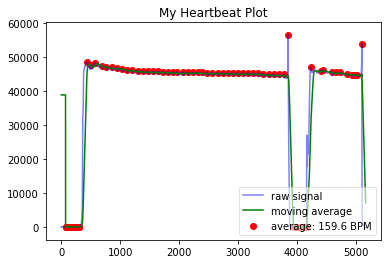

In [25]:
 process(dataset, 0.75, fs)

In [26]:
dataset2 = dataset[900:3500].reset_index(drop=True) #For visibility take a subselection of the entire signal from samples 1000 - 3500 
 

/home/levimmartins/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=74,center=False).mean()
  


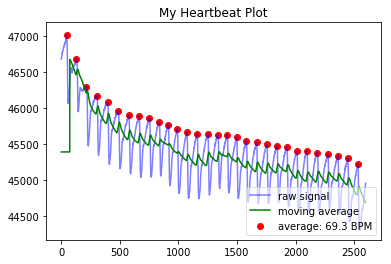

In [27]:
process(dataset2, 0.75, fs)

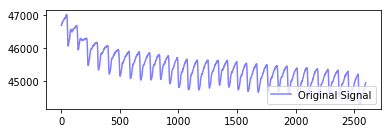

In [290]:
#Plot it (Seleção de dataset em estado original)
plt.subplot(211)
plt.plot(dataset2.hart, color='Blue', alpha=0.5, label='Original Signal')
plt.legend(loc=4)
plt.show()

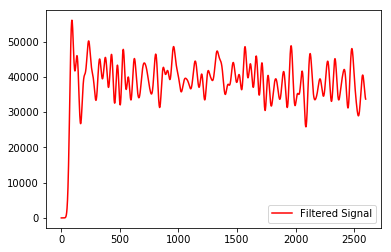

In [28]:
filtered = butter_lowpass_filter(dataset2.hart, 2.2, 99.0, 14)#filter the signal with a cutoff at 2.2Hz and a 14th order Butterworth filter

#Plot it (Seleção de dataset em após filtro)
#plt.subplot(212)
plt.plot(filtered, color='Red', label='Filtered Signal')
plt.legend(loc=4)
plt.show()

In [29]:
dataset2.hart = filtered

/home/levimmartins/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=74,center=False).mean()
  


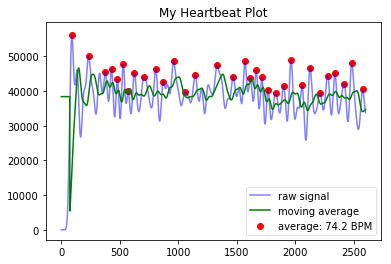

In [30]:
process(dataset2, 0.75, fs)

In [16]:
dataset.hart_rollingmean

0       38940.986270
1       38940.986270
2       38940.986270
3       38940.986270
4       38940.986270
5       38940.986270
6       38940.986270
7       38940.986270
8       38940.986270
9       38940.986270
10      38940.986270
11      38940.986270
12      38940.986270
13      38940.986270
14      38940.986270
15      38940.986270
16      38940.986270
17      38940.986270
18      38940.986270
19      38940.986270
20      38940.986270
21      38940.986270
22      38940.986270
23      38940.986270
24      38940.986270
25      38940.986270
26      38940.986270
27      38940.986270
28      38940.986270
29      38940.986270
            ...     
5141    24699.040541
5142    24094.945946
5143    23490.756757
5144    22886.162162
5145    22281.243243
5146    21676.121622
5147    21070.797297
5148    20465.283784
5149    19859.716216
5150    19254.054054
5151    18648.405405
5152    18042.621622
5153    17436.675676
5154    16830.824324
5155    16224.445946
5156    15618.256757
5157    15011

In [17]:
dataset.hart_rollingmean[5000]

44775.324324324327

In [18]:
dataset.hart_rollingmean[2000]

45302.08108108108

In [19]:
dataset.hart_rollingmean[3000]

45073.324324324327

In [20]:
 dataset.hart_rollingmean[1000]

46576.594594594593

In [21]:
 dataset.hart_rollingmean[340] 


194.47297297297297

38940.98626958035

69.26417370325693